In [1]:
import numpy as np
import pickle
import utils
import matplotlib.pyplot as plt

import textwrap

You've been hired by an eccentric bike company as an AI engineer to help with their prototyping software. For your probationary assignment, company has asked for a tool to help their designers visualize design concepts. They want to provide a partial image, some design parameters that they have selected for the design, and a marketing prompt. Your job is to use your AI magic to create a visualization of the completed design concept. However, your manager has "thrown you off the deep end," and isn't the best at answering your questions. For example, since you have no idea how to interpret the designers' jargon, you have no idea what each parameter is referring to on the bike! A lot of the bikes also look very strange or even physically infeasible and nobody seems to be able to explain why. In any case, it's not your business. Fortunately the company has provided a set of 10,000 previous design concepts (these engineers stay busy!) along with their parameters and marketing pitches. This gives you some hope to train a genrative model! For your probationary assessment, the company has also provided 1000 test designs to evaluate, but has not provided the completed images. They want you to use your "AI magic" to predict the complete designs and they will evaluate how accurately you were able to do so. 

### Exploring The Data

We have prepared a helper function to load up the data. LEt's call that function and take a look at the different components of our data

In [2]:
masked_images, masks, parametric, description, images = utils.load_data()

In [3]:
print(f"Masked images: array with shape: {masked_images.shape}")
print(f"Masks: array with shape: {masks.shape}")
print(f"Parametric: array with shape: {parametric.shape}")
print(f"Description: list with length: {len(description)}")
print(f"Images: array with shape: {images.shape}")

Masked images: array with shape: (10000, 3, 136, 214)
Masks: array with shape: (10000, 4)
Parametric: array with shape: (10000, 97)
Description: list with length: 10000
Images: array with shape: (10000, 3, 136, 214)


Let's have a look at the first entry of the parametric data. We can see that we have a few specified parametric values that aren't labeled in any way. the rest of the values are nans.  

In [4]:
parametric[0]

array([           nan,            nan,            nan, 4.95964516e+02,
                  nan, 1.31141113e+02,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan, 2.18610830e+01,            nan,
                  nan, 3.06095728e+01,            nan,            nan,
                  nan,            nan,            nan, 1.35300393e+01,
                  nan, 3.44191730e-01,            nan,            nan,
                  nan, 1.10000000e+00,            nan,            nan,
                  nan,            nan, 4.96935219e+02, 6.12624222e+01,
       4.83649049e+02,            nan,            nan,            nan,
                  nan,            nan,            nan, 6.87309604e+02,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan, 8.37418064e+01,
                  nan,            nan, 5.99467921e+01, 6.76637626e+01,
      

Ok, now let's take a look at the complete images, masked images and the marketing descriptions:

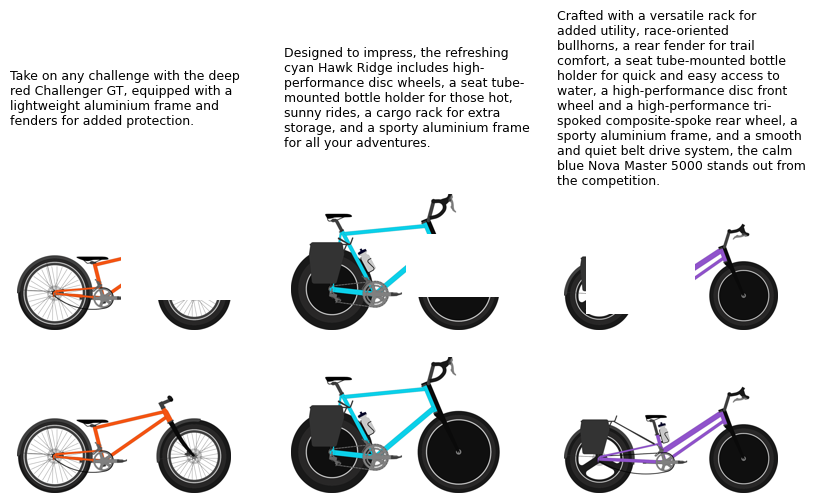

In [5]:
# Visualize 5 masked and complete images side by side
fig, ax = plt.subplots(3, 3, figsize=(10, 6))
for i in range(3):
    wrapped_text = "\n".join(textwrap.wrap(description[i], width=37))  
    ax[0, i].text(0, 0.5, wrapped_text, fontsize=9, va='center')  # Use va='center' and adjust y position
    masked_im = np.moveaxis(masked_images[i], 0, -1)
    im = np.moveaxis(images[i], 0, -1)
    ax[1, i].imshow(masked_im)
    ax[2, i].imshow(im)
    
    # Turn off axes
    ax[0, i].axis("off")
    ax[1, i].axis("off")
    ax[2, i].axis("off")

plt.show()


In case there is any ambiguity about the mask locations, these are provided too. Let's take a look at the mask information for these three bikes. The mask information contains the indices of the edges of the mask (order: left, bottom, right, top). Remember that we count pixels from top to bottom when dealing with numpy arrays.

In [6]:
masks[:3]

array([[ 72, 111, 174,   4],
       [ 29, 101, 159,  14],
       [ 57, 135, 177,  57]])

### Starter Code

In [7]:
#if we just submitted the masked images to predict the complete images:

utils.calculate_error(masked_images[:100], images[:100])

np.float32(0.090309784)

255.0


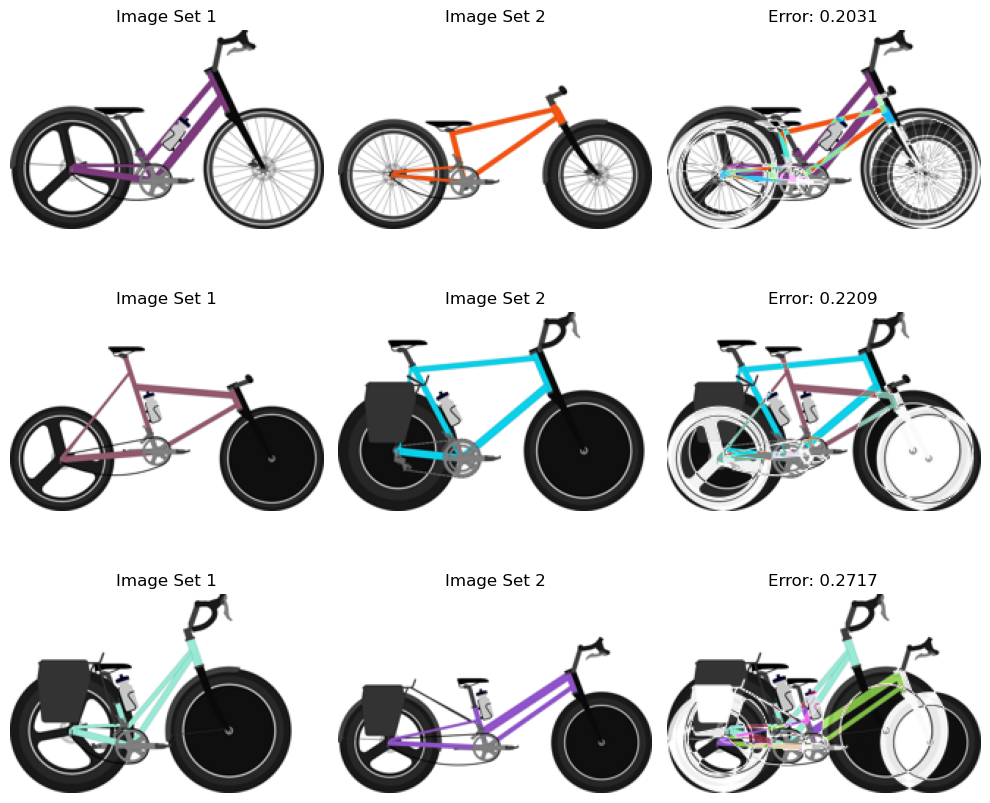

255.0


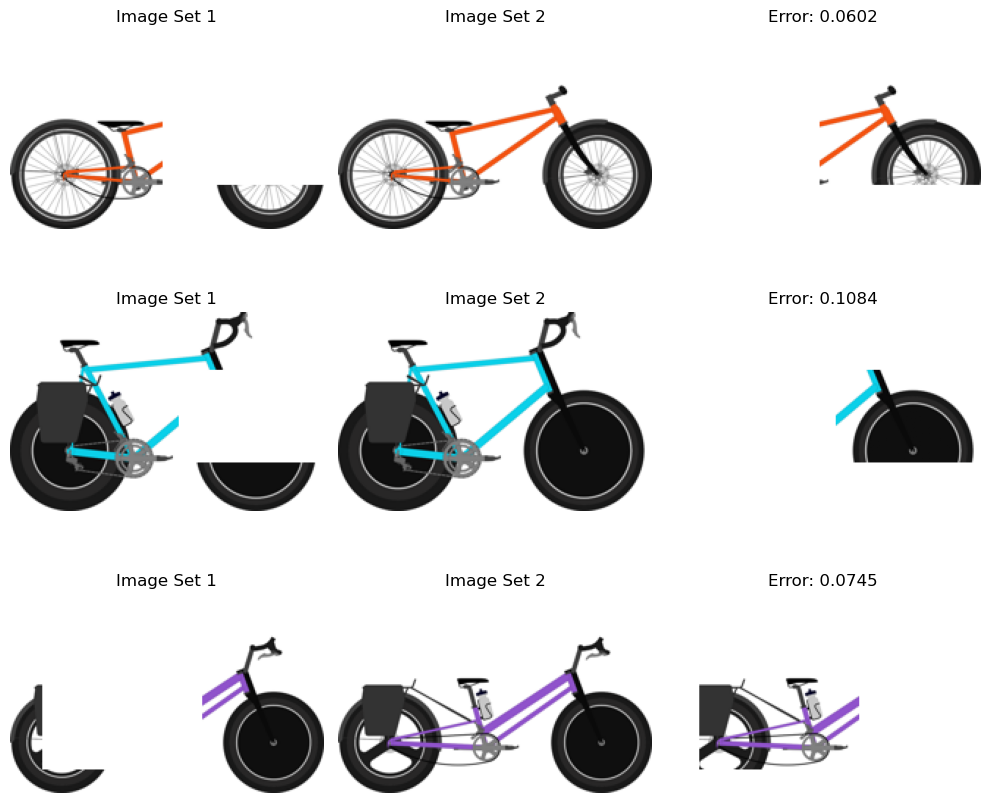

In [8]:

utils.display_images_residual(images[3:6], images[:3])

utils.display_images_residual(masked_images[:3], images[:3])


### Prepare your Submission

In [9]:
masked_images_test, masks_test, parametric_test, description_test, _ = utils.load_data("test") # images_test is not provided. You need to predict image_test. 

Make sure your data is scaled correctly! We expect your images to be scaled from 0-255. 